In [3]:
import pyLDAvis.gensim
#from pipeline import TopicModeller
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")
from gensim import corpora
#pyLDAvis.enable_notebook()
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel, LdaMulticore
#import tm_functions
import matplotlib.pyplot as plt
%matplotlib inline

import re
import tm_functions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/midzay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
import string
from nltk.corpus import stopwords

In [6]:
stop_words = stopwords.words('russian')
STOPLIST = set(stop_words)
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”","«","»"]

In [7]:
with open('../../../../nlp/preprocessing/stopwords.txt') as sw:
    text =sw.read().splitlines()
for t in text:
    STOPLIST.add(t)
STOPLIST.add('—')

In [8]:
PATH ='/home/midzay/Mlerning/DATASET/proj_news_viz/small/lemma/'
file='kultura.csv.bz2'

In [9]:
data = pd.read_csv(PATH + file , encoding='utf-8')
data.head()

,1914-lenta/,url,edition,topics,title,text,topic,text_lema
0,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/gmn/,NaN,Мир,Плачидо Доминго стал арт-директором музыкально...,Всемирно известный итальянский тенор Плачидо Д...,Культура,всемирно известный итальянский тенор плачидо д...
1,1999-10-07 12:00:00,https://lenta.ru/news/1999/10/07/bulgakov/,NaN,Россия,Академия художеств выбирает проект памятника Б...,В Москве на Патриарших прудах будет установлен...,Культура,москва патриарший пруд установленный памятник ...
2,1999-10-11 12:00:00,https://lenta.ru/news/1999/10/11/sapgir/,NaN,Россия,Умер поэт Генрих Сапгир,7 октября на 71-м году жизни умер выдающийся р...,Культура,7 71-м жизнь умереть выдающийся русский поэт п...
3,1999-10-13 12:00:00,https://lenta.ru/news/1999/10/13/aznavour/,NaN,Мир,Шарль Азнавур попал в аварию,Популярный французский певец и актер Шарль Азн...,Культура,популярный французский певец актёр шарль азнав...
4,1999-10-13 12:00:00,https://lenta.ru/news/1999/10/13/intourist/,NaN,Россия,"К 2002 году на Тверской построят новый ""Интурист""","Новая гостиница ""Интурист"" будет построена на ...",Культура,новый гостиница интурист построить тверская 20...


In [10]:
def pre_proc(text):
    tokens = [tok for tok in text.split() if tok not in STOPLIST]
    return tokens
    

In [11]:
data['new_text']=data.text_lema.apply(pre_proc)

In [12]:
data.head()

,1914-lenta/,url,edition,topics,title,text,topic,text_lema,new_text
0,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/gmn/,NaN,Мир,Плачидо Доминго стал арт-директором музыкально...,Всемирно известный итальянский тенор Плачидо Д...,Культура,всемирно известный итальянский тенор плачидо д...,"[всемирно, известный, итальянский, тенор, плач..."
1,1999-10-07 12:00:00,https://lenta.ru/news/1999/10/07/bulgakov/,NaN,Россия,Академия художеств выбирает проект памятника Б...,В Москве на Патриарших прудах будет установлен...,Культура,москва патриарший пруд установленный памятник ...,"[москва, патриарший, пруд, установленный, памя..."
2,1999-10-11 12:00:00,https://lenta.ru/news/1999/10/11/sapgir/,NaN,Россия,Умер поэт Генрих Сапгир,7 октября на 71-м году жизни умер выдающийся р...,Культура,7 71-м жизнь умереть выдающийся русский поэт п...,"[7, 71-м, жизнь, умереть, выдающийся, русский,..."
3,1999-10-13 12:00:00,https://lenta.ru/news/1999/10/13/aznavour/,NaN,Мир,Шарль Азнавур попал в аварию,Популярный французский певец и актер Шарль Азн...,Культура,популярный французский певец актёр шарль азнав...,"[популярный, французский, певец, актёр, шарль,..."
4,1999-10-13 12:00:00,https://lenta.ru/news/1999/10/13/intourist/,NaN,Россия,"К 2002 году на Тверской построят новый ""Интурист""","Новая гостиница ""Интурист"" будет построена на ...",Культура,новый гостиница интурист построить тверская 20...,"[новый, гостиница, интурист, построить, тверск..."


### Модель

In [13]:
%%time
dictionary = corpora.Dictionary(data['new_text'].values)

CPU times: user 9.23 s, sys: 11.4 ms, total: 9.24 s
Wall time: 9.39 s


In [14]:
%%time
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data['new_text'].values]

CPU times: user 7.43 s, sys: 211 ms, total: 7.64 s
Wall time: 7.83 s


In [15]:
num_topic=15

In [16]:
%%time
ldamodel1 = LdaModel(doc_term_matrix, num_topics=num_topic, id2word = dictionary, passes=10, alpha='auto', eta=None, random_state=42)

perplexity = ldamodel1.log_perplexity(doc_term_matrix)
coherence_model_lda = CoherenceModel(model=ldamodel1, texts=data['new_text'].values, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'Perplexity: {perplexity}')
print(f'Coherence Score: {coherence_lda}')

Perplexity: -8.862702908394931
Coherence Score: 0.5978358836681181
CPU times: user 33min 2s, sys: 3.35 s, total: 33min 5s
Wall time: 27min 3s


### Топ-топики в текстах

In [17]:
%%time
df_topic_sents_keywords = tm_functions.format_topics_sentences(ldamodel=ldamodel1, corpus=doc_term_matrix,
                                                               texts=data['new_text'].values)

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']



CPU times: user 5min 40s, sys: 567 ms, total: 5min 41s
Wall time: 5min 42s


In [18]:
df_dominant_topic.head(15)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,9.0,0.3398,"театр, опера","[всемирно, известный, итальянский, тенор, плач..."
1,1,6.0,0.3959,проект,"[москва, патриарший, пруд, установленный, памя..."
2,2,14.0,0.4645,,"[7, 71-м, жизнь, умереть, выдающийся, русский,..."
3,3,14.0,0.4368,,"[популярный, французский, певец, актёр, шарль,..."
4,4,6.0,0.4004,проект,"[новый, гостиница, интурист, построить, тверск..."
5,5,12.0,0.5672,"россия, российский","[брифинг, брюссель, официальный, европейский, ..."
6,6,6.0,0.3572,выставка,"[москва, открыться, международный, торгово-про..."
7,7,6.0,0.3612,произведение,"[польский, задержать, 29-летний, болгарский, г..."
8,8,2.0,0.3399,,"[саррота, автор, 20, книга, пьеса, роман, эссе..."
9,9,6.0,0.4023,проект,"[текстологический, экспетриза, подтвердить, не..."


### Статистика по топикам

In [19]:
%%time
top_indices = df_topic_sents_keywords.groupby('Dominant_Topic')['Perc_Contribution'].nlargest(1).reset_index()['level_1']
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
condition = df_topic_sents_keywords.index.isin(top_indices)
topic_num_keywords = df_topic_sents_keywords[condition][['Dominant_Topic', 'Topic_Keywords']].reset_index(drop=True)

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

CPU times: user 62.6 ms, sys: 15 µs, total: 62.7 ms
Wall time: 304 ms


### График по времени

In [20]:
%%time
data['date'] = data['url'].apply(lambda x: pd.to_datetime('-'.join(x.split('/')[4:7])))
data['year_month'] = data['date'].values.astype('datetime64[M]')

data['topics'] = [ldamodel1.get_document_topics(i) for i in doc_term_matrix]
data['topics_dict'] = data['topics'].apply(lambda x: {i[0]: i[1] for i in x})

for i in range(ldamodel1.num_topics):
    data['topic_' + str(i)] = data['topics_dict'].apply(lambda x: x[i] if i in x.keys() else 0)
    
data = data.sort_values('year_month')

data.loc[data['year_month'] == '1914-09-01 00:00:00', 'year_month'] = pd.Timestamp(year=2014, month=9, day=1, hour=0)

data.to_csv('/home/midzay/Mlerning/DATASET/proj_news_viz/small/update/kultura_update.csv.bz2',compression='bz2', index=False)

CPU times: user 2min 24s, sys: 312 ms, total: 2min 24s
Wall time: 2min 24s


In [21]:
topic_cols = [col for col in data.columns if 'topic_' in col]
a = data.groupby(['year_month'])[topic_cols].mean()#.plot(stacked=True, figsize=(12, 8))

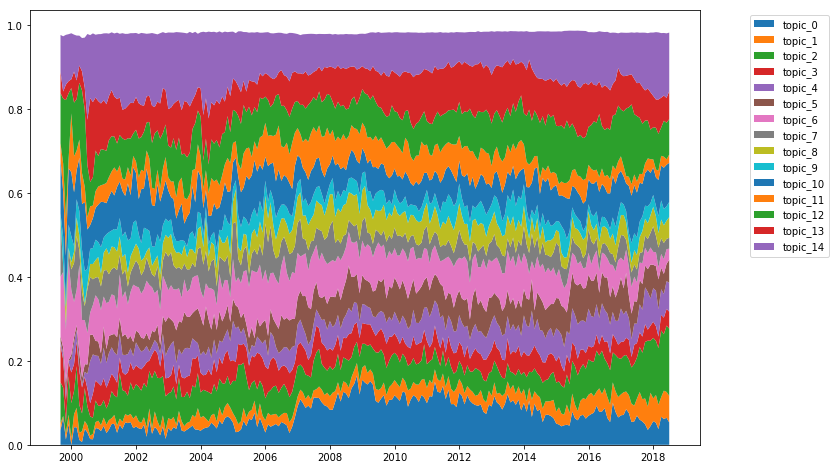

In [22]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.stackplot(a.index, a.T.values, labels=list(a.columns))
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
plt.show()

### Слова в топиках

In [23]:
ldamodel1.print_topics()

[(0,
  '0.031*"альбом" + 0.025*"музыкант" + 0.018*"концерт" + 0.015*"песня" + 0.014*"коллектив" + 0.011*"композиция" + 0.011*"пластинка" + 0.010*"выпустить" + 0.010*"песнь" + 0.009*"выступление"'),
 (1,
  '0.024*"певица" + 0.018*"рэпер" + 0.016*"опубликовать" + 0.014*"клип" + 0.014*"видео" + 0.013*"список" + 0.011*"хороший" + 0.011*"ролик" + 0.010*"песня" + 0.010*"американский"'),
 (2,
  '0.011*"смерть" + 0.009*"артист" + 0.007*"певец" + 0.007*"скончаться" + 0.007*"произойти" + 0.007*"причина" + 0.006*"актёр" + 0.006*"больница" + 0.005*"умереть" + 0.005*"из-за"'),
 (3,
  '0.040*"книга" + 0.025*"роман" + 0.022*"писатель" + 0.015*"автор" + 0.013*"написать" + 0.011*"опубликовать" + 0.010*"произведение" + 0.007*"язык" + 0.006*"писательница" + 0.006*"издание"'),
 (4,
  '0.034*"сериал" + 0.029*"актёр" + 0.022*"роль" + 0.022*"актриса" + 0.014*"сезон" + 0.013*"американский" + 0.010*"сыграть" + 0.008*"игра" + 0.008*"продюсер" + 0.007*"эпизод"'),
 (5,
  '0.025*"фильм" + 0.012*"прокат" + 0.010*"с

### Топ слова.

In [24]:
word_counts = {}
for s in tqdm_notebook(doc_term_matrix):
    for w in s:
        if w[0] not in word_counts:
            word_counts[w[0]] = w[1]
        else:
            word_counts[w[0]] += w[1]

In [25]:
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

In [26]:
for w in sorted_word_counts[:50]:
    print(f'{dictionary[w[0]]} - {w[1]} times.')

фильм - 61375 times.
картина - 33949 times.
the - 26607 times.
режиссёр - 23430 times.
миллион - 22586 times.
роль - 21812 times.
доллар - 18831 times.
актёр - 18386 times.
премия - 16528 times.
хороший - 16417 times.
новый - 15953 times.
альбом - 15581 times.
театр - 15310 times.
проект - 13961 times.
лента - 13533 times.
американский - 13328 times.
книга - 12976 times.
главный - 12923 times.
россия - 12866 times.
последний - 12842 times.
известный - 12791 times.
российский - 12770 times.
музей - 12464 times.
музыкант - 11706 times.
день - 10840 times.
концерт - 10579 times.
тысяча - 10496 times.
фестиваль - 10407 times.
большой - 10027 times.
сайт - 10024 times.
участие - 9995 times.
британский - 9761 times.
сыграть - 9590 times.
сша - 9510 times.
состояться - 9462 times.
место - 9333 times.
прокат - 9264 times.
москва - 9251 times.
написать - 9195 times.
роман - 9131 times.
искусство - 9057 times.
сериал - 8859 times.
художник - 8784 times.
история - 8540 times.
автор - 8397 times.
